# Tutorial 10: Adversarial attacks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under%20development&color=red)

**Filled notebook:** 
[![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)

**Pre-trained models and dataset:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial10)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1k01P6w31VOW9TT0gTEP9kog315qyiXCd?usp=sharing)

In this tutorial, we will discuss adversarial attacks on deep image classification models. As we have seen in many of the previous tutorials so far, Deep Neural Networks are a very powerful tool to recognize patterns in data, and, for example, perform image classification on human-level. However, we have not tested yet how robust these models actually are. Can we "trick" the model and find failure modes? Can we design images that the networks naturally classify incorrectly? Due to the high classification accuracy on unseen test data, we would expect that this can be difficult. However, in 2014, a research group at Google and NYU showed that deep CNNs can be easily fooled, just by adding some salient, but carefully constructed noise to the images. For instance, take a look at the example below (figure credit - [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf)):

<center width="100%" style="padding: 20px"><img src="adversarial_example.svg" width="550px"></center>

The image on the left is the original image from ImageNet, and a deep CNN classifies the image correctly as "panda" with a class likelihood of 57%. Nevertheless, if we add a little noise to every pixel of the image, the prediction of the model changes completely. Instead of a panda, our CNN tells us that the image contains a "gibbon" with a confidence of over 99%. For a human, however, these two images looks exactly alike, and you cannot distinguish which one has noise added and which doesn't. To understand what makes CNNs vulnerable to such attacks, we will implement our own adversarial attack strategies in this notebook, and try to fool a deep neural network.

Let's being with importing our standard libraries:

In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


## Pretrained Models on ImageNet

In [2]:
import os
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)
pretrained_model = pretrained_model.to(device)

pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [3]:
# No resizing and center crop necessary as images are already preprocessed.
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), "Could not find the ImageNet dataset at expected path \"%s\". " % imagenet_path + \
                                     "Please make sure to have downloaded the ImageNet dataset here, or change the DATASET_PATH variable (currently set to %s)." % DATASET_PATH
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)
    
def get_label_index(lab_str):
    assert lab_str in label_names, "Label \"%s\" not found. Check the spelling of the class." % lab_str
    return label_names.index(lab_str)

In [4]:
pretrained_model.eval()
tp = 0.0
counter = 0
with torch.no_grad():
    for imgs, labels in tqdm(data_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = pretrained_model(imgs)
        preds = preds.argmax(dim=-1)
        tp += (preds == labels).sum()
        counter += preds.shape[0]
print("Accuracy", tp.float()/counter)


Accuracy tensor(0.8090, device='cuda:0')


In [5]:
def show_prediction(img, label, pred, K=5):
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    fig, ax = plt.subplots(1,2, figsize=(8,2.5))
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[1].set_yticks(np.arange(K))
    ax[1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[1].invert_yaxis()
    ax[1].set_xlabel('Probability')
    ax[1].set_title('Predictions')
    fig.subplots_adjust(hspace=0.4)
    
    plt.show()
    plt.close()

In [6]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
    preds = torch.softmax(preds, dim=-1)

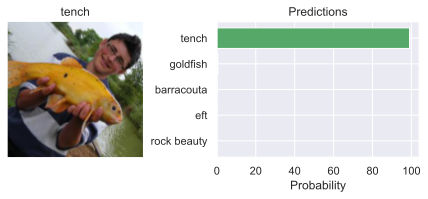

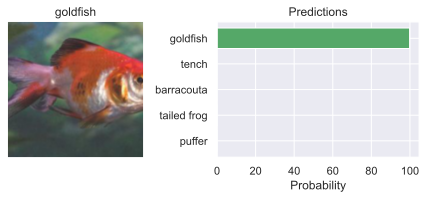

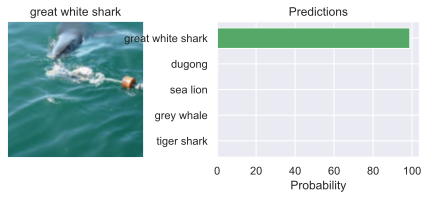

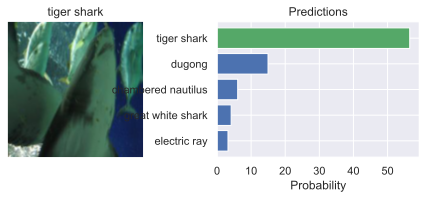

In [7]:
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

## White-box adversarial attacks

### Fast Gradient Sign Method (FGSM)

Explaining and Harnessing Adversarial Examples (https://arxiv.org/pdf/1412.6572.pdf)

(224, 224, 1)
(4, 224, 224, 3)


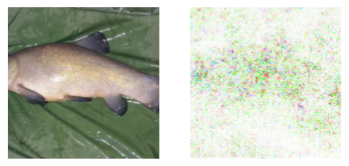

(224, 224, 1)
(4, 224, 224, 3)


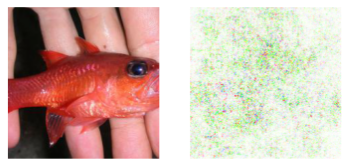

(224, 224, 1)
(4, 224, 224, 3)


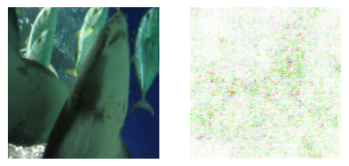

(224, 224, 1)
(4, 224, 224, 3)


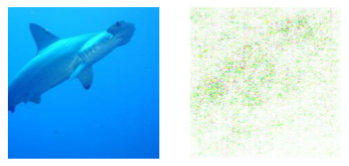

In [8]:
def visualize_attention(model, imgs, labels):
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    loss = torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    grad_intensity = inp_imgs.grad.abs()
    
    imgs = imgs.permute(0,2,3,1).cpu().numpy()
    imgs = (imgs * NORM_STD[None,None]) + NORM_MEAN[None,None]
    imgs = np.clip(imgs, a_min=0.0, a_max=1.0)
    grad_intensity = grad_intensity.permute(0,2,3,1).cpu().numpy()
    for i in range(imgs.shape[0]):
        fig, ax = plt.subplots(1,2)
        
        ax[0].imshow(imgs[i])
        ax[0].axis('off')
        
        # ax[1].imshow(imgs[i])
        alpha_channel = grad_intensity[i].max(axis=-1, keepdims=True) / grad_intensity[i].max() * 4
        alpha_channel = np.clip(alpha_channel, a_min=0.0, a_max=1.0)
        grad_intensity[i] = grad_intensity[i] / grad_intensity[i].max(axis=-1, keepdims=True)
        print(alpha_channel.shape)
        print(grad_intensity.shape)
        ax[1].imshow(np.concatenate([grad_intensity[i], alpha_channel], axis=-1))
        ax[1].axis('off')
        
        plt.show()
        plt.close()

exmp_batch, label_batch = next(iter(data_loader))

visualize_attention(pretrained_model, exmp_batch[:32:8], label_batch[:32:8])

Test to run the adversarial attack multiple times, adjusting the noise

In [9]:
def adversarial_attack(model, imgs, labels, target_labels=None, noise_level=0.07):
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    if target_labels is None:
        loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    else:
        loss = torch.gather(preds, 1, target_labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    print(noise_grad.shape)
    fake_imgs = imgs + noise_level * noise_grad
    return fake_imgs, noise_grad

exmp_batch_2, noise_grad = adversarial_attack(pretrained_model, exmp_batch, label_batch)
print((exmp_batch[0] - exmp_batch_2[0]).abs().max())
with torch.no_grad():
    preds_2 = pretrained_model(exmp_batch_2.to(device))
    preds_2 = torch.softmax(preds_2, dim=-1)
print((preds_2[0] - preds[0]).abs().max())

torch.Size([32, 3, 224, 224])
tensor(0.0700)
tensor(0.9732, device='cuda:0')


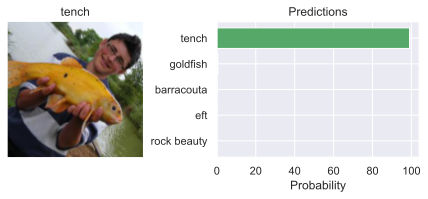

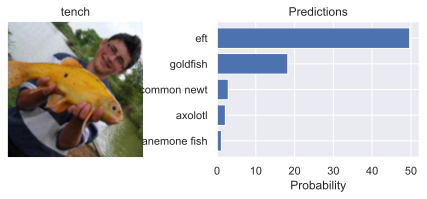

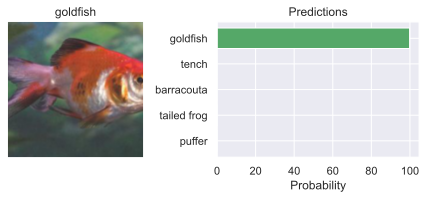

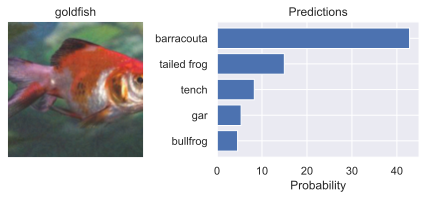

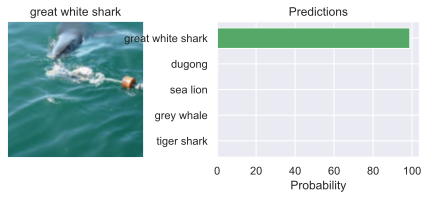

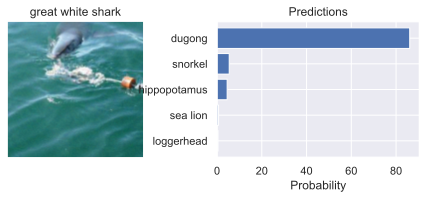

In [10]:
for i in range(1,12,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])
    show_prediction(exmp_batch_2[i], label_batch[i], preds_2[i])

In [11]:
exmp_batch_3, noise_grad = adversarial_attack(pretrained_model, exmp_batch, label_batch, target_labels=torch.ones_like(label_batch), noise_level=0.05)
print((exmp_batch[0] - exmp_batch_3[0]).abs().max())
with torch.no_grad():
    preds_3 = pretrained_model(exmp_batch_3.to(device))
    preds_3 = torch.softmax(preds_3, dim=-1)
print((preds_3[0] - preds[0]).abs().max())

torch.Size([32, 3, 224, 224])
tensor(0.0500)
tensor(0.7758, device='cuda:0')


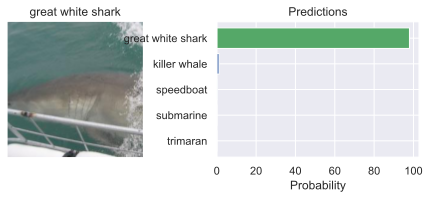

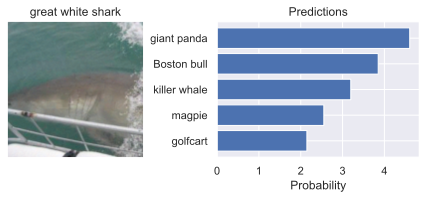

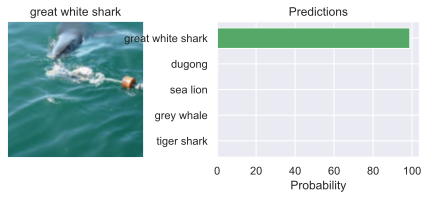

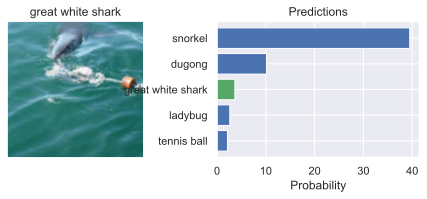

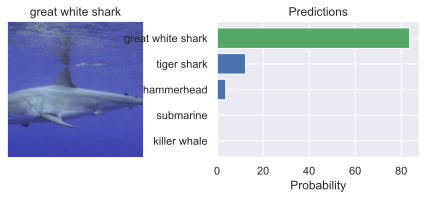

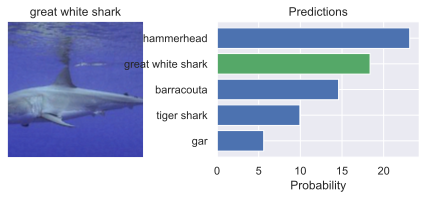

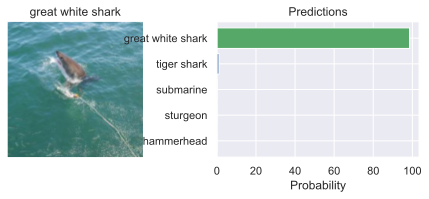

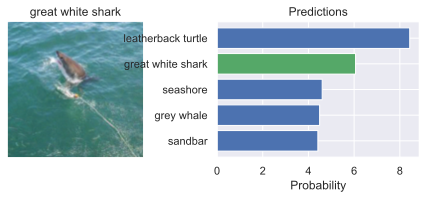

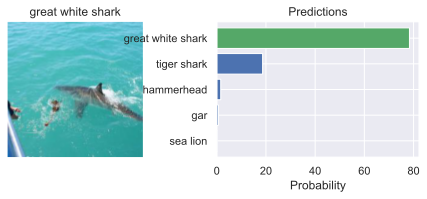

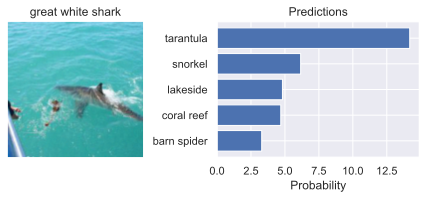

In [12]:
for i in range(10,15): # np.random.randint(0,exmp_batch.shape[0]-1,2):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])
    show_prediction(exmp_batch_3[i], label_batch[i], preds_3[i])

### Adversarial Patch

Adversarial Patch (https://arxiv.org/pdf/1712.09665.pdf)

In [13]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

def show_patch(patch, target_class):
    patch = patch.detach().cpu().permute(1, 2, 0).numpy()
    patch = (patch * NORM_STD[None,None]) + NORM_MEAN[None,None]
    patch = np.clip(patch, a_min=0.0, a_max=1.0)
    plt.imshow(patch)
    plt.title(label_names[target_class])
    plt.axis('off')
    plt.show()
    plt.close()

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating..."):
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    print("Fool accuracy: %4.2f%% (Top-5: %4.2f%%)" % (acc*100.0, top5*100.0))
    return acc, top5

def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
        
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description("Epoch %i, Loss: %4.2f" % (epoch, loss.item()))
    
    show_patch(patch, target_class)
    
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    
    return patch.data, {"acc": acc, "top5": top5}

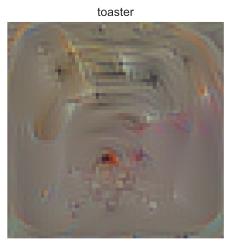


Fool accuracy: 97.65% (Top-5: 99.80%)


In [14]:
patch, results = patch_attack(pretrained_model, target_class=859, patch_size=64, num_epochs=2)

In [15]:
exmp_batch_4 = exmp_batch.clone()
exmp_batch_4 = place_patch(exmp_batch_4, patch)
with torch.no_grad():
    preds_4 = pretrained_model(exmp_batch_4.to(device))
    preds_4 = torch.softmax(preds_4, dim=-1)

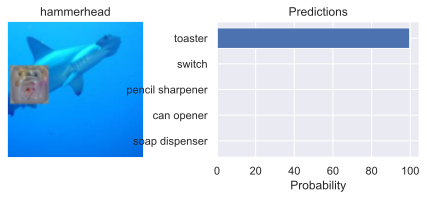

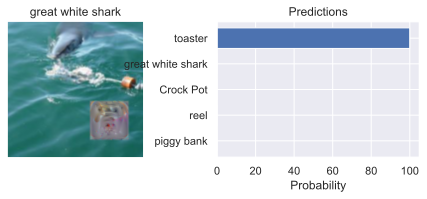

In [16]:
for i in np.random.randint(0,exmp_batch_4.shape[0]-1,2):
    show_prediction(exmp_batch_4[i], label_batch[i], preds_4[i])

In [17]:
print(label_names.index('toaster'))
sorted(label_names)[:10]

859


['Afghan hound',
 'African chameleon',
 'African crocodile',
 'African elephant',
 'African grey',
 'African hunting dog',
 'Airedale',
 'American Staffordshire terrier',
 'American alligator',
 'American black bear']

In [19]:
# show_prediction(patch, label=torch.LongTensor([939]), pred=None)

## Transferibility of white-box attacks

In [20]:
another_network = torchvision.models.mobilenet_v2(pretrained=True)
another_network = another_network.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to ../saved_models/tutorial10/hub/checkpoints/mobilenet_v2-b0353104.pth


In [21]:
_ = eval_patch(another_network, patch, data_loader, target_class=get_label_index('toaster'))


Fool accuracy: 16.62% (Top-5: 41.45%)


## Protecting against adversarial attacks

## Conclusion

## References

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.